# Colapse all simulation into a unique .feather file

In [3]:
import glob, os
import pandas as pd
import numpy as np
from scipy.stats import ecdf, wasserstein_distance

df_complete_file = 'df_complete_ex1.feather' # https://pandas.pydata.org/docs/user_guide/io.html#feather
if ( os.path.exists(df_complete_file) ):
    print(f'{df_complete_file} already exists. Reading it.')
    df_all = pd.read_feather(df_complete_file)
else:
    print(f'{df_complete_file} does not exists. Generating it.')
    data_files = glob.glob('../output_SA_ex1/SummaryFile_*.feather')
    df_all = pd.concat((pd.read_feather(file) for file in data_files), ignore_index=True)
    df_all.to_feather(df_complete_file)

params_list = ['cycle_tumor_base','necrosis_tumor_base','tumor2motile_base','cycle_motile_base','necrosis_motile_base',
               'cycle_tumor_sat','cycle_tumor_hfm','cycle_tumor_hp',
                   'mechano_tumor_hfm','mechano_tumor_hp',
                   'necrosis_tumor_hfm','necrosis_tumor_hp',
                   'tumor2motile_hfm','tumor2motile_hp',
                   'cycle_motile_sat', 'cycle_motile_hfm', 'cycle_motile_hp',
                   'mechano_motile_hfm', 'mechano_motile_hp',
                   'necrosis_motile_hfm', 'necrosis_motile_hp',
                   'motile2tumor_sat', 'motile2tumor_hfm', 'motile2tumor_hp']
df_all # 233530 rows = 193 samples * 10 repplicates * 121 time points

df_complete_ex1.feather already exists. Reading it.


,time,replicate,sample,runtime,tumor_live,tumor_dead,motile_live,motile_dead,dist_tumor_live,dist_tumor_dead,...,cycle_motile_sat,cycle_motile_hfm,cycle_motile_hp,mechano_motile_hfm,mechano_motile_hp,necrosis_motile_hfm,necrosis_motile_hp,motile2tumor_sat,motile2tumor_hfm,motile2tumor_hp
0,0.0,4,107,0.000024,2000,0,0,0,"[77.9878646113564, 257.21390187394763, 225.465...",[],...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.00
1,60.0,4,107,1.424883,1971,53,59,1,"[77.275806223348, 259.0251499857681, 232.97420...","[330.0727888976101, 329.4770231444414, 179.320...",...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.00
2,120.0,4,107,2.637469,1863,96,120,6,"[81.49872598675346, 259.584509925866, 234.3937...","[68.749630939196, 332.58504467623186, 59.12970...",...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.00
3,180.0,4,107,3.740179,1799,126,158,11,"[81.75172711972465, 260.21224452866056, 234.87...","[70.02253725444162, 333.81173196946605, 58.836...",...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.00
4,240.0,4,107,4.853511,1743,148,198,15,"[82.61854715483837, 260.76848265531856, 237.02...","[71.03552287740165, 251.38219708074263, 334.83...",...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233525,6960.0,8,185,180.035991,2011,495,239,177,"[292.0375374270333, 358.849235600439, 389.1548...","[333.48678311537867, 120.82893194408948, 317.8...",...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,7.92
233526,7020.0,8,185,181.820037,1997,494,254,177,"[291.9200156695263, 358.41506773608637, 389.53...","[334.87528761179783, 121.25870429995692, 317.7...",...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,7.92
233527,7080.0,8,185,183.592083,1993,496,261,179,"[292.36275089583216, 359.34127700888195, 390.2...","[334.4524371650632, 121.44998808581252, 315.67...",...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,7.92
233528,7140.0,8,185,185.392647,2013,496,248,180,"[293.9236083609693, 360.344020684836, 390.5400...","[335.64544197169243, 121.79449346716736, 312.8...",...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,7.92


# Define the QoIs: AUC of each mean population, weithed mean and pooled std of distance from the center in the last time

- Population: store the population of each cell type over time.
    - Summary over time and replicates: Area under curve (AUC) of the average populations.
- Invasion: Distance of cells from the center - provides insights into the spatial distribution and invasion characteristics of the cells.
    - Summary over time and replicates: Pooling the distances from replicates and calculate the Wassertein distance between tumor and motile.


In [4]:
df_summary_file = 'df_summary_ex1.feather' # https://pandas.pydata.org/docs/user_guide/io.html#feather
if ( os.path.exists(df_summary_file) ):
    print(f'{df_summary_file} already exists. Reading it.')
    df_summary = pd.read_feather(df_summary_file)
else:
    print(f'{df_summary_file} does not exists. Generating it.')

    # Exclude columns with numpy arrays before calculating the mean
    exclude_cols = ['dist_tumor_live', 'dist_tumor_dead', 'dist_motile_live', 'dist_motile_dead']
    df_summary_temp = df_all.drop(columns=exclude_cols).groupby(['sample', 'time'], as_index=False).mean()
    df_summary_temp = df_summary_temp.drop(columns=['replicate'])

    # Replace the mean of distributions to concatenate each replicate samples - row dimension of samples x time points
    for col in exclude_cols:
        concatenated = df_all.groupby(['sample', 'time'])[col].apply(
            lambda x: np.concatenate([y for y in x if y.size > 0 and y.ndim > 0]) if any(y.size > 0 and y.ndim > 0 for y in x) else np.array([])
        ).reset_index(drop=True)
        df_summary_temp[col] = concatenated
    
    # Function to calculate AUC using trapezoidal rule for trajectories
    def calculate_auc_multiple(group):
        auc_values = {}
        for col in ['tumor_live', 'tumor_dead', 'motile_live', 'motile_dead']: # QoI columns of cell population  
            mask_notna = group[col].notna()  
            auc_values[f'AUC_{col}'] = np.trapezoid(group[col][mask_notna], group['time'][mask_notna])
        return pd.Series(auc_values)
    # Group by 'Sample_ID' then calculate AUC for each QOI - row dimension of samples
    df_auc = df_summary_temp.groupby(['sample']).apply(calculate_auc_multiple).reset_index() # calculate the AUC for each QOI
    
    # Function to calculate Wasserstein distance between tumor and motile cells 
    def calculate_wassertein_dist(group):
        wasserstein_values = {}
        # Define empirical distributions of tumor and motile cells
        emp_liveTumor_cdf = ecdf(group['tumor_live'].to_numpy())
        emp_liveMotile_cdf = ecdf(group['motile_live'].to_numpy())
        wasserstein_values['Wasserstein_dist'] = wasserstein_distance(emp_liveTumor_cdf.cdf.quantiles, emp_liveMotile_cdf.cdf.quantiles, emp_liveTumor_cdf.cdf.probabilities, emp_liveMotile_cdf.cdf.probabilities)
        return pd.Series(wasserstein_values)
    # Group by 'Sample_ID' then calculate Wasserstein distance between tumor and motile cells - row dimension of samples
    df_distance = df_summary_temp[ df_summary_temp['time'] == 7200.0 ].groupby(['sample']).apply(calculate_wassertein_dist).reset_index()

    # Merge the AUC values and Wasserstein distance to the summary dataframe
    df_summary = df_auc.merge(df_distance, on=['sample'])
    
    # Merge the parameters to the summary dataframe
    df_summary = df_summary.merge(df_summary_temp[ df_summary_temp['time'] == 7200.0 ][['sample']+ params_list], on=['sample'])


    df_summary.to_feather(df_summary_file)

df_summary

df_summary_ex1.feather does not exists. Generating it.


/tmp/ipykernel_85671/1622252816.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_auc = df_summary_temp.groupby(['sample']).apply(calculate_auc_multiple).reset_index() # calculate the AUC for each QOI
/tmp/ipykernel_85671/1622252816.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_distance = df_summary_temp[ df_summary_temp['time'] == 7200.0 ].groupby(['sample']).apply(calculate_wassertein_dist

,sample,AUC_tumor_live,AUC_tumor_dead,AUC_motile_live,AUC_motile_dead,Wasserstein_dist,cycle_tumor_base,necrosis_tumor_base,tumor2motile_base,cycle_motile_base,...,cycle_motile_sat,cycle_motile_hfm,cycle_motile_hp,mechano_motile_hfm,mechano_motile_hp,necrosis_motile_hfm,necrosis_motile_hp,motile2tumor_sat,motile2tumor_hfm,motile2tumor_hp
0,0,12585177.0,2594274.0,1607553.0,864186.0,1824.6,0.000720,0.0028,0.001,0.00072,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.0
1,1,12554385.0,2550465.0,1581216.0,874494.0,1828.1,0.000713,0.0028,0.001,0.00072,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.0
2,2,12598353.0,2582190.0,1600212.0,887025.0,1849.1,0.000727,0.0028,0.001,0.00072,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.0
3,3,12546819.0,2544669.0,1579359.0,900648.0,1839.2,0.000684,0.0028,0.001,0.00072,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.0
4,4,12574389.0,2623593.0,1598298.0,862356.0,1817.9,0.000756,0.0028,0.001,0.00072,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,188,12547587.0,2570892.0,1620177.0,869181.0,1816.2,0.000720,0.0028,0.001,0.00072,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.4
189,189,12667215.0,2565039.0,1580751.0,882894.0,1864.4,0.000720,0.0028,0.001,0.00072,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,7.2
190,190,12618909.0,2528511.0,1642353.0,924876.0,1849.4,0.000720,0.0028,0.001,0.00072,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.8
191,191,12753066.0,2685759.0,1562127.0,799644.0,1869.1,0.000720,0.0028,0.001,0.00072,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,6.4


# Local sensitivity analysis: 
Give $\theta^\star$ as the reference parameter set, we added a multiplicative perturbation $\delta$, which
$$\theta_i = \theta^\star \times (1\pm \delta), \quad \delta = \{0.01, 0.05, 0.1, 0.2\}$$

Absolute sensitivity (A unit increase in $\theta_i$ changes the output by $S_{\theta_i}$ units): 
$$S_{\theta_i} = \dfrac{f(\theta_i)-f(\theta^\star)}{\theta_i - \theta^\star}$$
Relative sensitivity (Elasticity -  For every $1\%$ change in $\theta_i$, the output changes by $\bar{S}_{\theta_i} \times 1\%$:

$$\bar{S}_{\theta_i} = \dfrac{f(\theta_i)-f(\theta^\star)}{f(\theta^\star)}\cdot \dfrac{\theta^\star}{\theta_i - \theta^\star}$$

- $S>0:$ As the parameter increases, the output also increases.
- $S<0:$ As the parameter increases, the output decreases.
- $S=0:$ The output is insensitive to changes in the parameter.
- $∣S∣≫1:$ The output is highly sensitive to the parameter; small changes in the parameter will cause large changes in the output.
- $∣S∣≪1:$ The output is relatively insensitive to the parameter; large changes in the parameter will have little effect on the output.

In [5]:
sample_ref = 0 # Sample with reference parameters
print('Sample with reference parameters: ', df_summary.iloc[sample_ref][params_list].values)

# Calculate the sensitivity index
QoIs_list = ['AUC_tumor_live', 'AUC_tumor_dead', 'AUC_motile_live', 'AUC_motile_dead', 'Wasserstein_dist']
# Function to calculate SI using
def calculate_SI_multiple():
    sensitivity_analysis_dic = {}
    # Calculate the delta of parameters
    non_zero_values = []; non_zero_params= []
    relative_change_params = (df_summary[params_list] - df_summary.iloc[sample_ref][params_list].values) / np.where(df_summary.iloc[sample_ref][params_list].values != 0, df_summary.iloc[sample_ref][params_list].values, 1)
    for index, row in relative_change_params.iterrows():
        # First index is the reference sample - include the value 1 and skip it
        if index == sample_ref: non_zero_values.append(1); non_zero_params.append(params_list[0]); continue
        # Get the non-zero values in the row
        non_zero_row_values = row[row != 0.0]
        # Check if there is exactly one non-zero value
        if len(non_zero_row_values) == 1: non_zero_values.append(non_zero_row_values.iloc[0])
        else: raise ValueError(f"Row {index} contains more than one non-zero value or all values are zero. Non zero: {non_zero_row_values} - Row: {row.values}")
        # Parameter name with non-zero value
        non_zero_params.append(non_zero_row_values.index[0])
    relative_change_params_1d = pd.DataFrame(non_zero_values, columns=['NonZeroValues'])
    sensitivity_analysis_dic['SA_parameter'] = np.array(non_zero_params)
    sensitivity_analysis_dic['SA_delta'] = relative_change_params_1d.to_numpy()[:,0].round(2)
    # Calculate the delta of QoIs
    absolute_change_qois = df_summary[QoIs_list] - df_summary.iloc[sample_ref][QoIs_list].values
    relative_change_qois = absolute_change_qois / np.where(df_summary.iloc[sample_ref][QoIs_list].values != 0, df_summary.iloc[sample_ref][QoIs_list].values, 1)
    absolute_change_params = sensitivity_analysis_dic['SA_delta'] * df_summary.iloc[sample_ref][ sensitivity_analysis_dic['SA_parameter'] ].to_numpy()
    for id_qoi, qoi in enumerate(QoIs_list): 
        sensitivity_analysis_dic[f'SI_{qoi}'] = relative_change_qois.to_numpy()[:,id_qoi]/sensitivity_analysis_dic['SA_delta']
        parameter_name = sensitivity_analysis_dic['SA_parameter']
        sensitivity_analysis_dic[f'Abs_SI_{qoi}'] = absolute_change_qois.to_numpy()[:,id_qoi]/absolute_change_params
    
    # Change the delta of reference value to 0 and label it as reference
    sensitivity_analysis_dic['SA_delta'][0] = 0
    sensitivity_analysis_dic['SA_parameter'][0] = 'Reference'
    return pd.DataFrame(sensitivity_analysis_dic)

# Group by 'Sample_ID' then calculate AUC for each QOI - row dimension of samples
df_SA = calculate_SI_multiple() # calculate the AUC for each QOI
df_SA = pd.concat([df_summary['sample'], df_SA], axis=1)

# Print the sensitivity index
for qoi in QoIs_list:
    sample_lowest_qoi = df_summary.iloc[df_summary[qoi].idxmin()]['sample']; sample_highest_qoi = df_summary.iloc[df_summary[qoi].idxmax()]['sample']
    sample_lowest_si = df_SA.iloc[df_SA[f'SI_{qoi}'].idxmin()]['sample']; sample_highest_si = df_SA.iloc[df_SA[f'SI_{qoi}'].idxmax()]['sample']
    print(f"QoI: {qoi}")
    print(f"\t lowest and highest QoI: {sample_lowest_qoi} ({df_SA.iloc[int(sample_lowest_qoi)]['SA_parameter']}) and {sample_highest_qoi} ({df_SA.iloc[int(sample_highest_qoi)]['SA_parameter']})")
    print(f"\t lowest and highest SI: {sample_lowest_si} ({df_SA.iloc[int(sample_lowest_si)]['SA_parameter']}) and {sample_highest_si} ({df_SA.iloc[int(sample_highest_si)]['SA_parameter']})\n")
df_SA

Sample with reference parameters:  [7.20e-04 2.80e-03 1.00e-03 7.20e-04 2.80e-03 7.20e-03 2.15e+01 4.00e+00
 2.50e-01 3.00e+00 3.75e+00 8.00e+00 6.75e+00 8.00e+00 7.20e-03 2.15e+01
 4.00e+00 2.50e-01 3.00e+00 3.75e+00 8.00e+00 5.00e-03 6.75e+00 8.00e+00]
QoI: AUC_tumor_live
	 lowest and highest QoI: 184.0 (motile2tumor_hfm) and 55.0 (cycle_tumor_hfm)
	 lowest and highest SI: 169 (motile2tumor_sat) and 186 (motile2tumor_hp)

QoI: AUC_tumor_dead
	 lowest and highest QoI: 87.0 (necrosis_tumor_hfm) and 88.0 (necrosis_tumor_hfm)
	 lowest and highest SI: 114 (cycle_motile_sat) and 81 (necrosis_tumor_hfm)

QoI: AUC_motile_live
	 lowest and highest QoI: 103.0 (tumor2motile_hfm) and 184.0 (motile2tumor_hfm)
	 lowest and highest SI: 73 (mechano_tumor_hp) and 18 (tumor2motile_base)

QoI: AUC_motile_dead
	 lowest and highest QoI: 159.0 (necrosis_motile_hfm) and 160.0 (necrosis_motile_hfm)
	 lowest and highest SI: 81 (necrosis_tumor_hfm) and 154 (necrosis_motile_hfm)

QoI: Wasserstein_dist
	 lowest

,sample,SA_parameter,SA_delta,SI_AUC_tumor_live,Abs_SI_AUC_tumor_live,SI_AUC_tumor_dead,Abs_SI_AUC_tumor_dead,SI_AUC_motile_live,Abs_SI_AUC_motile_live,SI_AUC_motile_dead,Abs_SI_AUC_motile_dead,SI_Wasserstein_dist,Abs_SI_Wasserstein_dist
0,0,Reference,0.00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00
1,1,cycle_tumor_base,-0.01,0.244669,4.276667e+09,1.688681,6.084583e+09,1.638329,3.657917e+09,-1.192799,-1.431667e+09,-0.191823,-4.861111e+05
2,2,cycle_tumor_base,0.01,0.104695,1.830000e+09,-0.465795,-1.678333e+09,-0.456657,-1.019583e+09,2.642834,3.172083e+09,1.342760,3.402778e+06
3,3,cycle_tumor_base,-0.05,0.060957,1.065500e+09,0.382419,1.377917e+09,0.350769,7.831667e+08,-0.843846,-1.012833e+09,-0.160035,-4.055556e+05
4,4,cycle_tumor_base,0.05,-0.017144,-2.996667e+08,0.226029,8.144167e+08,-0.115144,-2.570833e+08,-0.042352,-5.083333e+07,-0.073441,-1.861111e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,188,motile2tumor_hp,0.05,-0.059737,-9.397500e+04,-0.180259,-5.845500e+04,0.157059,3.156000e+04,0.115600,1.248750e+04,-0.092075,-2.100000e+01
189,189,motile2tumor_hp,-0.10,-0.065186,-1.025475e+05,0.112690,3.654375e+04,0.166725,3.350250e+04,-0.216481,-2.338500e+04,-0.218130,-4.975000e+01
190,190,motile2tumor_hp,0.10,0.026803,4.216500e+04,-0.253493,-8.220375e+04,0.216478,4.350000e+04,0.702279,7.586250e+04,0.135920,3.100000e+01
191,191,motile2tumor_hp,-0.20,-0.066701,-1.049306e+05,-0.176321,-5.717812e+04,0.141289,2.839125e+04,0.373427,4.033875e+04,-0.121945,-2.781250e+01


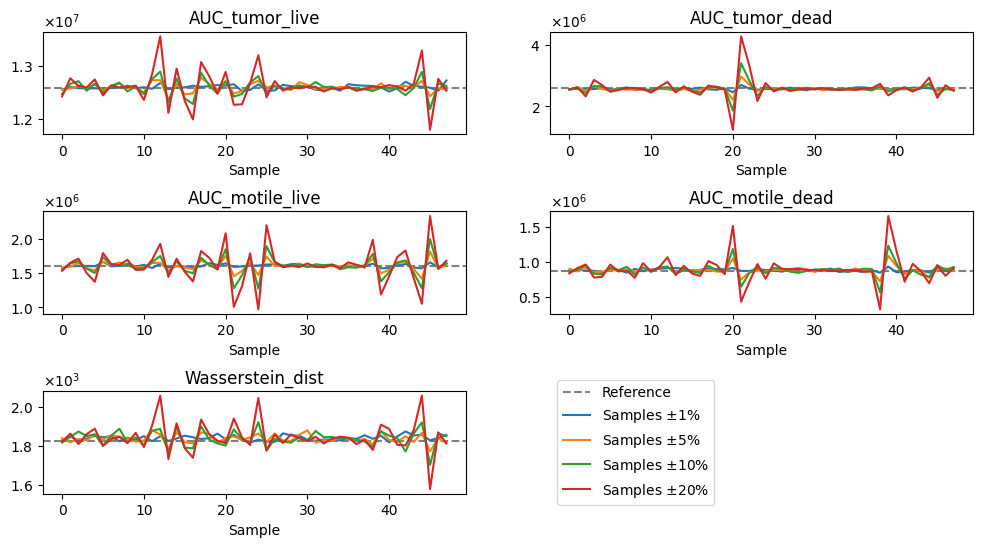

In [6]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.75)
for qoi, ax in zip(QoIs_list, axes.flatten()):
    ax.axhline(df_summary.iloc[sample_ref][qoi], color='gray', linestyle='--')
    samples_delta1 = df_SA[ (df_SA['SA_delta'] == -0.01) | (df_SA['SA_delta'] == 0.01) ]['sample'].values
    samples_delta5 = df_SA[ (df_SA['SA_delta'] == -0.05) | (df_SA['SA_delta'] == 0.05) ]['sample'].values
    samples_delta10 = df_SA[ (df_SA['SA_delta'] == -0.1) | (df_SA['SA_delta'] == 0.1) ]['sample'].values
    samples_delta20 = df_SA[( df_SA['SA_delta'] == -0.2) | (df_SA['SA_delta'] == 0.2) ]['sample'].values
    ax.plot(range(len(df_summary.iloc[samples_delta1]['sample'])), df_summary.iloc[samples_delta1][qoi])#, s=12)
    ax.plot(range(len(df_summary.iloc[samples_delta5]['sample'])), df_summary.iloc[samples_delta5][qoi])#, s=12)
    ax.plot(range(len(df_summary.iloc[samples_delta10]['sample'])), df_summary.iloc[samples_delta10][qoi])#, s=12)
    ax.plot(range(len(df_summary.iloc[samples_delta20]['sample'])), df_summary.iloc[samples_delta20][qoi])#, s=12)
    ax.set_title(qoi)
    ax.set_xlabel('Sample')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.yaxis.major.formatter._useMathText = True
axes[2, 1].remove()
plt.legend(labels=['Reference', r'Samples $\pm 1\%$', r'Samples $\pm 5\%$', r'Samples $\pm 10\%$', r'Samples $\pm 20\%$'],loc='center left', bbox_to_anchor=(1.2, 0.5))


plt.show()

/tmp/ipykernel_85671/1058788702.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SA['SA_delta'] = df_SA['SA_delta'].round(2)


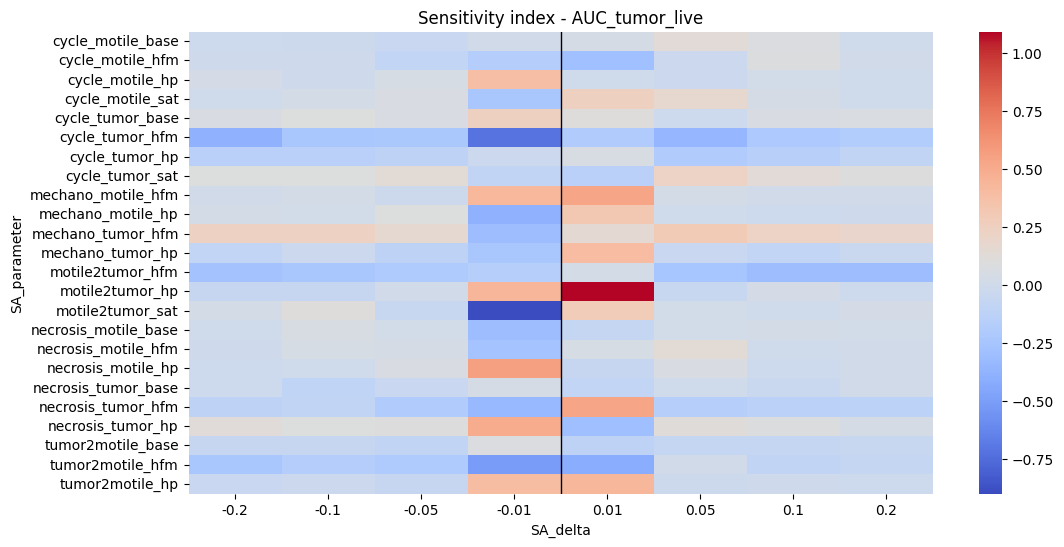

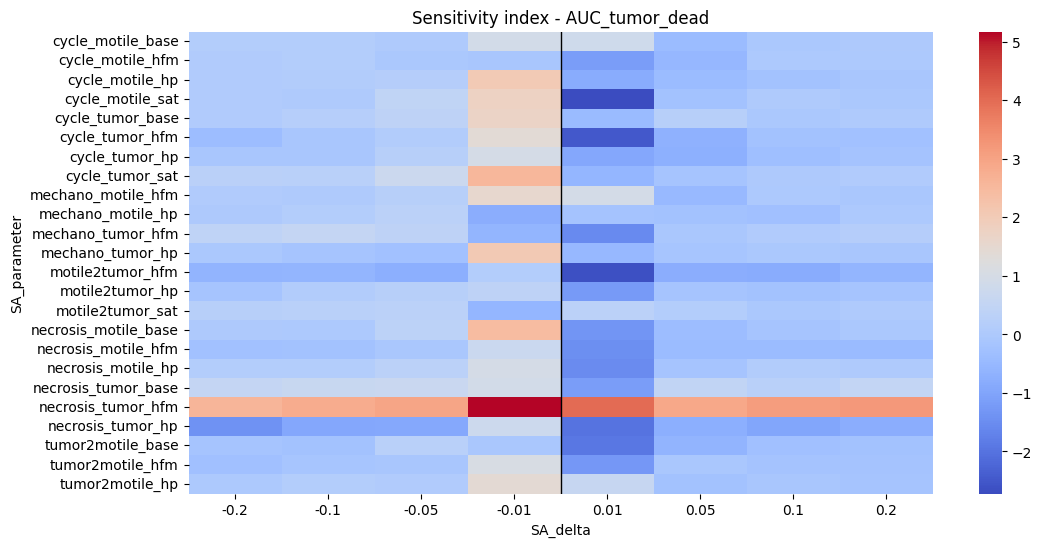

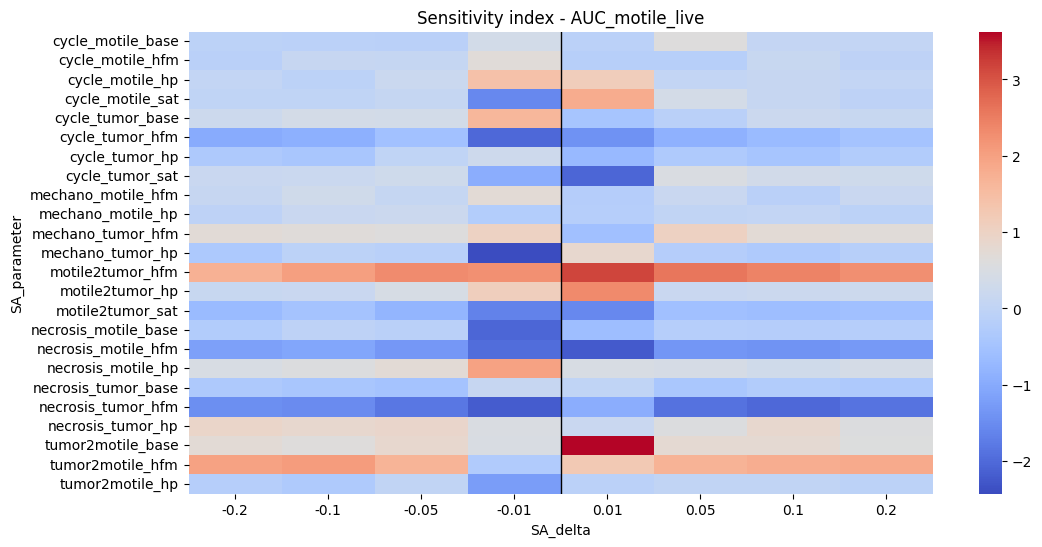

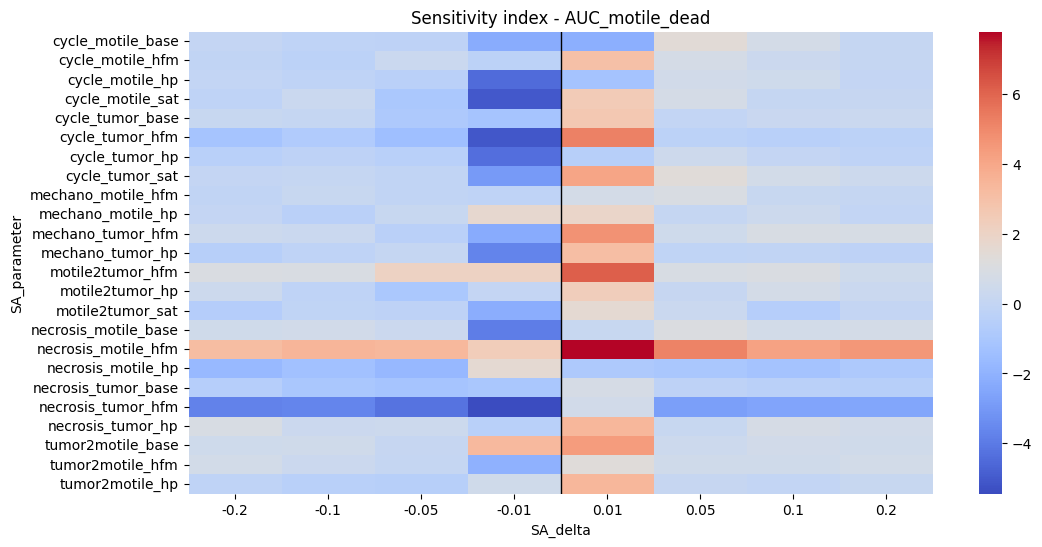

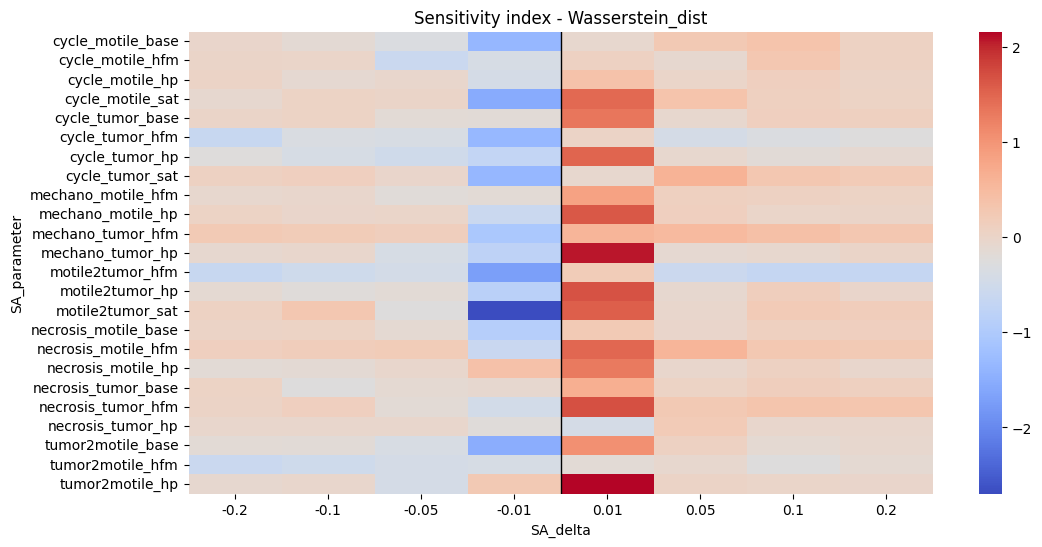

In [7]:
# Plot the sensitivity index as heatmap with the parameters vs delta and color as SI
import seaborn as sns

for qoi in QoIs_list:
    fig, ax = plt.subplots(figsize=(12, 6))
    # Round the values to 2 decimal places
    df_SA['SA_delta'] = df_SA['SA_delta'].round(2)
    # Drop the reference sample
    df_SA = df_SA[df_SA['sample'] != sample_ref]
    df_SA_pivot = df_SA.pivot(index="SA_parameter", columns="SA_delta", values="SI_"+qoi)
    sns.heatmap(df_SA_pivot, cmap='coolwarm', ax=ax)
    # draw a line to separate the positive and negative values
    ax.axvline(4, color='black', lw=1)
    ax.set_title(f'Sensitivity index - {qoi}')
plt.show()

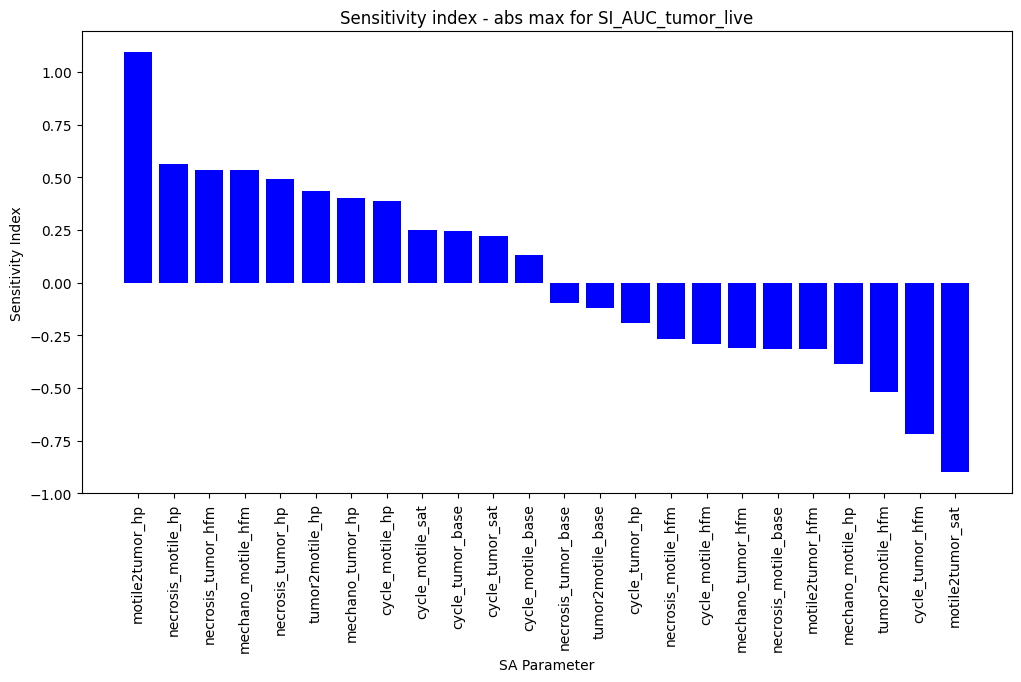

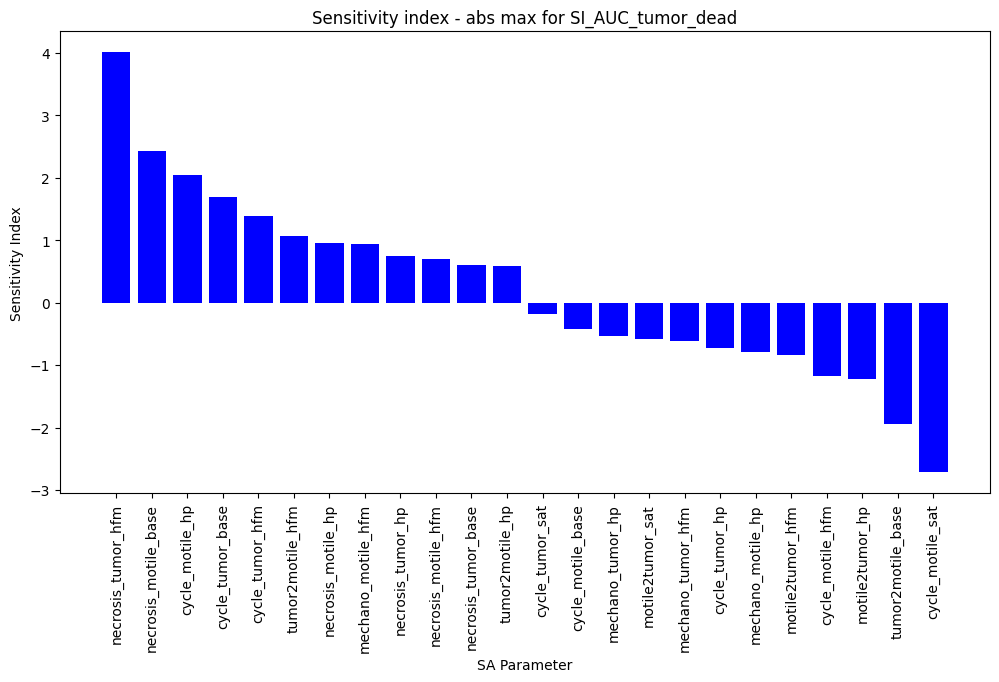

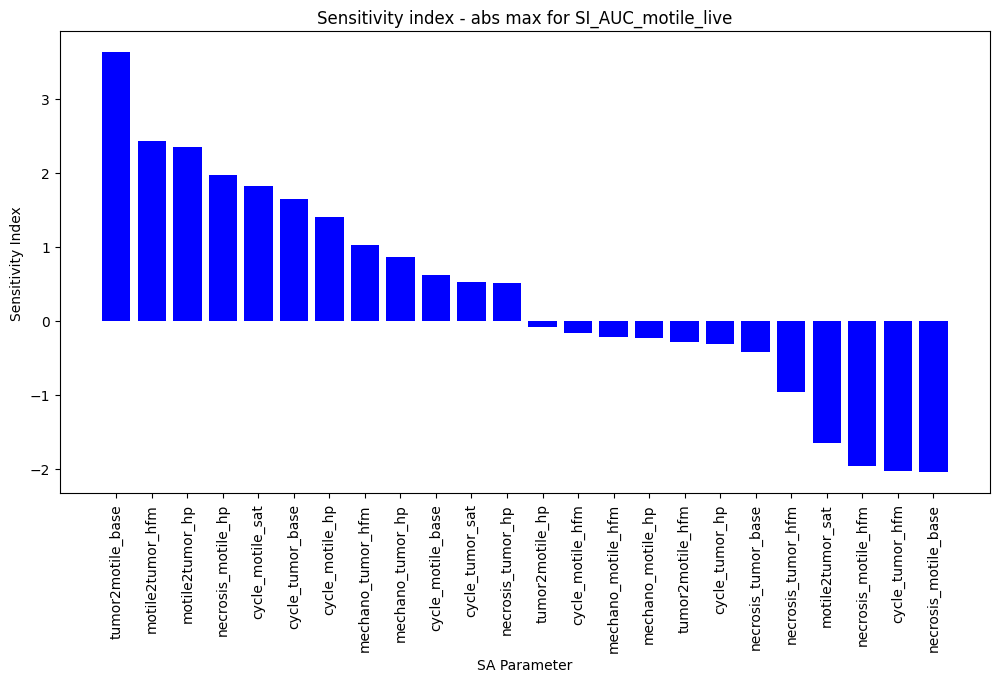

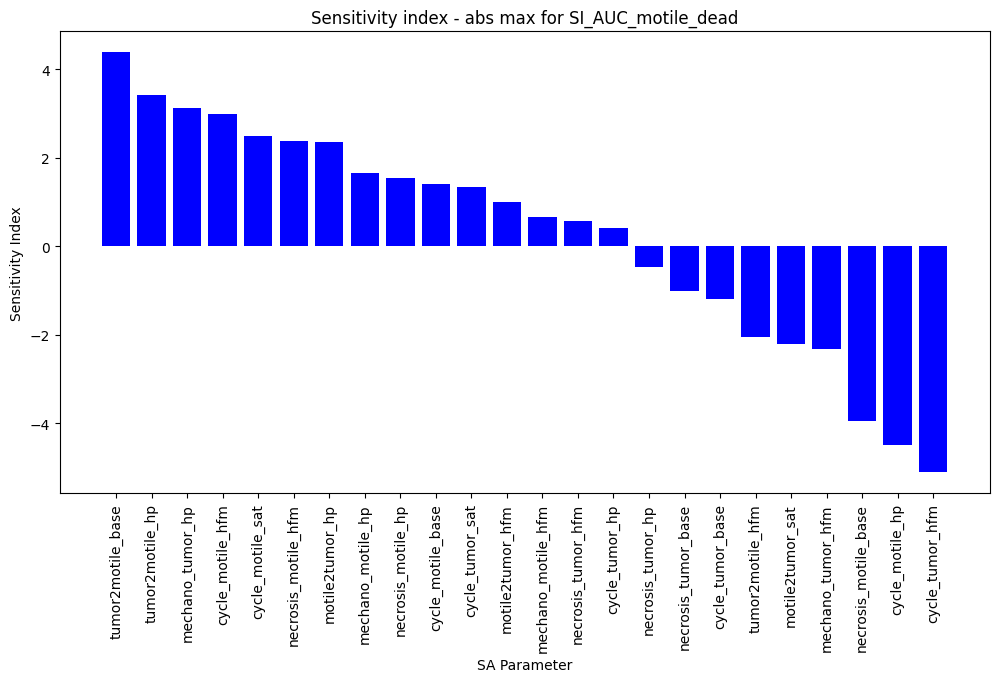

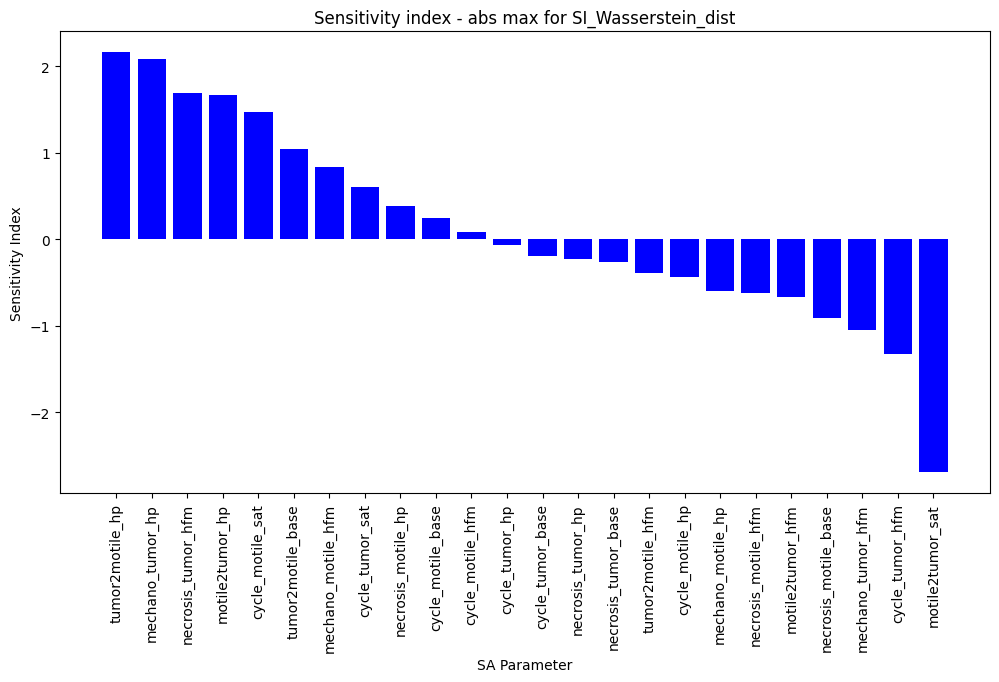

In [8]:
SI_list = [f'SI_{qoi}' for qoi in QoIs_list]

# Round the values to 2 decimal places
df_SA['SA_delta'] = df_SA['SA_delta'].round(2)
# Drop the reference sample
df_SA = df_SA[df_SA['sample'] != sample_ref]
# Calculate the absolute max sensitivity index for each parameter across all SA_delta
df_SA_max = df_SA.groupby(['SA_parameter'])[SI_list].apply(lambda x: x.loc[x.abs().idxmax(axis=0).iloc[0]]).reset_index()

# Pivot the dataframe to get the desired format
# Create a bar plot for each QoI
for qoi in SI_list:
    fig, ax = plt.subplots(figsize=(12, 6))
    df_SA_max_sorted = df_SA_max.sort_values(by=qoi, ascending=False)
    ax.bar(df_SA_max_sorted['SA_parameter'], df_SA_max_sorted[qoi], color='b')
    ax.set_title(f'Sensitivity index - abs max for {qoi}')
    ax.set_xlabel('SA Parameter')
    ax.set_ylabel('Sensitivity Index')
    plt.xticks(rotation=90)
    plt.show()

# Plot one figure with the abs max sensitivity index as heatmap with the parameters vs QOI and color as SI
# fig, ax = plt.subplots(figsize=(12, 6))
# df_SA_pivot = df_SA_max.pivot(index="SA_parameter", columns="SA_delta", values=SI_list)
# sns.heatmap(df_SA_pivot, cmap='coolwarm', ax=ax)
# ax.set_title('Sensitivity index - abs max')
# plt.show()